In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 

figure_width = 0.9

text_width = 5.59164
plt.rcParams.update({
    "text.usetex": False,
    "font.size": 12,
    "font.family" : "serif",
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": (figure_width * text_width, figure_width * text_width * 0.75),
    "image.cmap": "coolwarm",
    "figure.autolayout": True,
})

import numpy as np
import pyqula
from pyqula import geometry
import numba as nb

Chern number: 0.00
Chern number: 2.00


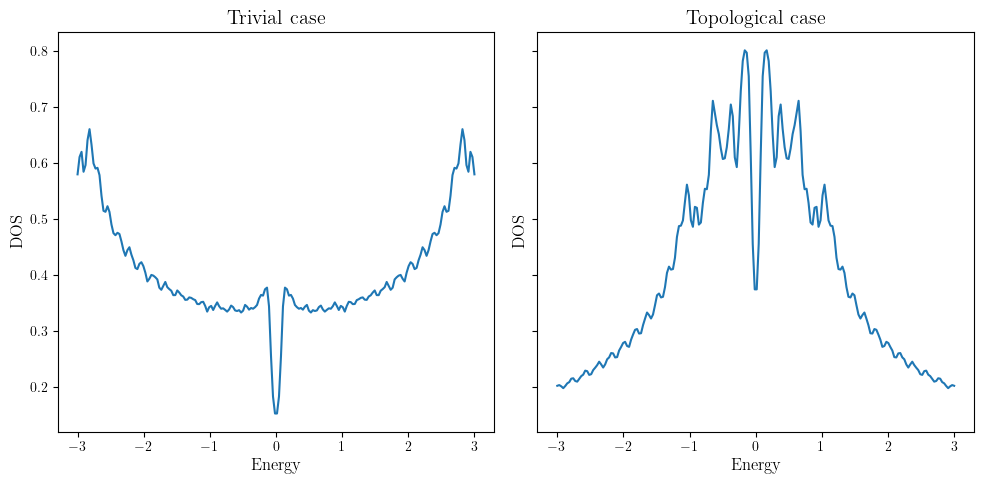

In [7]:
# Density of states
g = geometry.triangular_lattice()

h = g.get_hamiltonian()

h.add_rashba(0.3)
h.add_swave(0.1)
h.add_zeeman([0, 0, 0.2])
h.add_onsite(-1)
print(f"Chern number: {np.abs(h.get_chern(nk=50)):.2f}")

e = np.linspace(-3, 3, 200)
_, dos = h.get_dos(delta=5e-2, energies=e, write=False, nk=100)
fig, axs = plt.subplots(1, 2, sharey="all", figsize=(10, 5))
axs[0].plot(e, dos)
axs[0].set_xlabel("Energy")
axs[0].set_ylabel("DOS")
axs[0].set_title("Trivial case")

h = g.get_hamiltonian()

h.add_rashba(0.3)
h.add_swave(0.1)
h.add_zeeman([0, 0, 0.2])
h.add_onsite(2.85)
print(f"Chern number: {np.abs(h.get_chern(nk=50)):.2f}")

_, dos = h.get_dos(delta=5e-2, energies=e, write=False, nk=100)
axs[1].plot(e, dos)
axs[1].set_xlabel("Energy")
axs[1].set_ylabel("DOS")
axs[1].set_title("Topological case")

plt.savefig("physics/dos comparison.pdf")
plt.show()

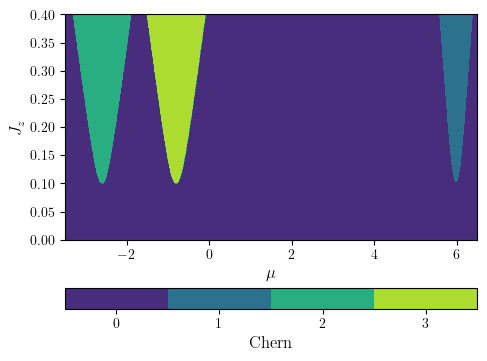

In [9]:
cmap = mpl.colormaps["viridis"]
levels = np.linspace(0, 3, 5) / 3

# Fill with a default background of 0
x = np.linspace(-3.5, 6.5, 10)
y = np.linspace(0, 0.4, 10)
X, Y = np.meshgrid(x, y)
z = np.ones_like(X) * 0
plt.contourf(X, Y, z, zorder=-1, levels=levels, vmin=0, vmax=1)

# Right side of the plot
c = np.load("../utils/chernGapRight.npy")[:, :, 0]
n = c.shape[0]
potential = np.linspace(5.5, 6.5, n)
zeeman = np.linspace(0, 0.4, n)
mu, zeeman = np.meshgrid(potential, zeeman)
c_plot = np.round(np.abs(c), 0) / 3
plt.contourf(mu, zeeman, c_plot, levels=levels, vmin=0, vmax=1)

# Left side of the plot
c = np.load("../utils/chernGapLeft.npy")[:, :, 0]
n = c.shape[0]
potential = np.linspace(-3.5, 1, n)
zeeman = np.linspace(0, 0.4, n)
mu, zeeman = np.meshgrid(potential, zeeman)
c_plot = np.round(np.abs(c), 0) / 3
plt.contourf(mu, zeeman, c_plot, levels=levels, vmin=0, vmax=1)

plt.set_cmap("viridis")
cb = plt.colorbar(label="Chern", orientation="horizontal")
labels = [0, 1, 2, 3]
distance = 1
loc = np.linspace(1/8, 7/8, 4)
cb.set_ticks(loc, labels=labels)

plt.xlabel("$\mu$", fontsize=12)
plt.ylabel("$J_z$", fontsize=12)

plt.savefig("physics/chern.pdf")
plt.show()

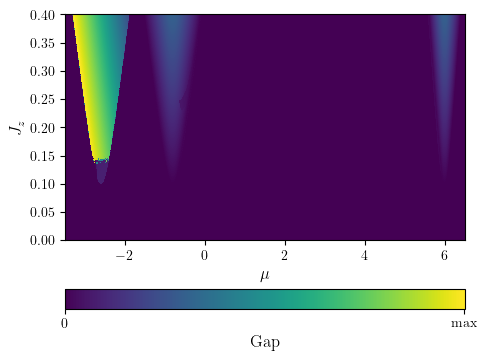

In [11]:
# Gap
chernGapL = np.load("../utils/chernGapLeft.npy")
chernGapR = np.load("../utils/chernGapRight.npy")

# Mask the topological regions
gapL = chernGapL[:, :, 1] * (np.round(np.abs(chernGapL[:, : ,0]), 0) > 0)
gapR = chernGapR[:, :, 1] * (np.round(np.abs(chernGapR[:, : ,0]), 0) > 0)

# Normalize
maxL = np.max(gapL)
maxR = np.max(gapR)
gapMax = max(maxL, maxR)
gapL /= gapMax
gapR /= gapMax

levels = 800

# Fill with a default background of 0
x = np.linspace(-3.5, 6.5, 10)
y = np.linspace(0, 0.4, 10)
X, Y = np.meshgrid(x, y)
z = np.ones_like(X) * 0
z[0, 0] = 1  # Hack to get the levels right

norm = mpl.colors.Normalize(0, 1)
cmap = mpl.cm.viridis

plt.contourf(X, Y, z, zorder=-1, levels=levels, cmap=cmap, norm=norm)

# Right side
n = gapR.shape[0]
muR, zeemanR = np.meshgrid(
    np.linspace(5.5, 6.5, n), np.linspace(0, 0.4, n))
plt.contourf(muR, zeemanR, gapR, levels=levels, antialiased=False, cmap=cmap, norm=norm)
plt.contourf(muR, zeemanR, gapR, levels=levels, antialiased=False, cmap=cmap, norm=norm)
plt.contourf(muR, zeemanR, gapR, levels=levels, antialiased=False, cmap=cmap, norm=norm)

# Left side
n = gapL.shape[0]
muL, zeemanL = np.meshgrid(
    np.linspace(-3.5, 1, n), np.linspace(0, 0.4, n))
plt.contourf(muL, zeemanL, gapL, levels=levels, antialiased=False, cmap=cmap, norm=norm)
plt.contourf(muL, zeemanL, gapL, levels=levels, antialiased=False, cmap=cmap, norm=norm)
plt.contourf(muL, zeemanL, gapL, levels=levels, antialiased=False, cmap=cmap, norm=norm)

plt.set_cmap("viridis")
cb = plt.colorbar(label="Gap", orientation="horizontal")
cb.set_ticks([0, 1], labels=["0", "max"])
cb.solids.set_edgecolor("face")

plt.xlabel("$\mu$", fontsize=12)
plt.ylabel("$J_z$", fontsize=12)

plt.savefig("physics/gap.png", dpi=1000)
plt.show()

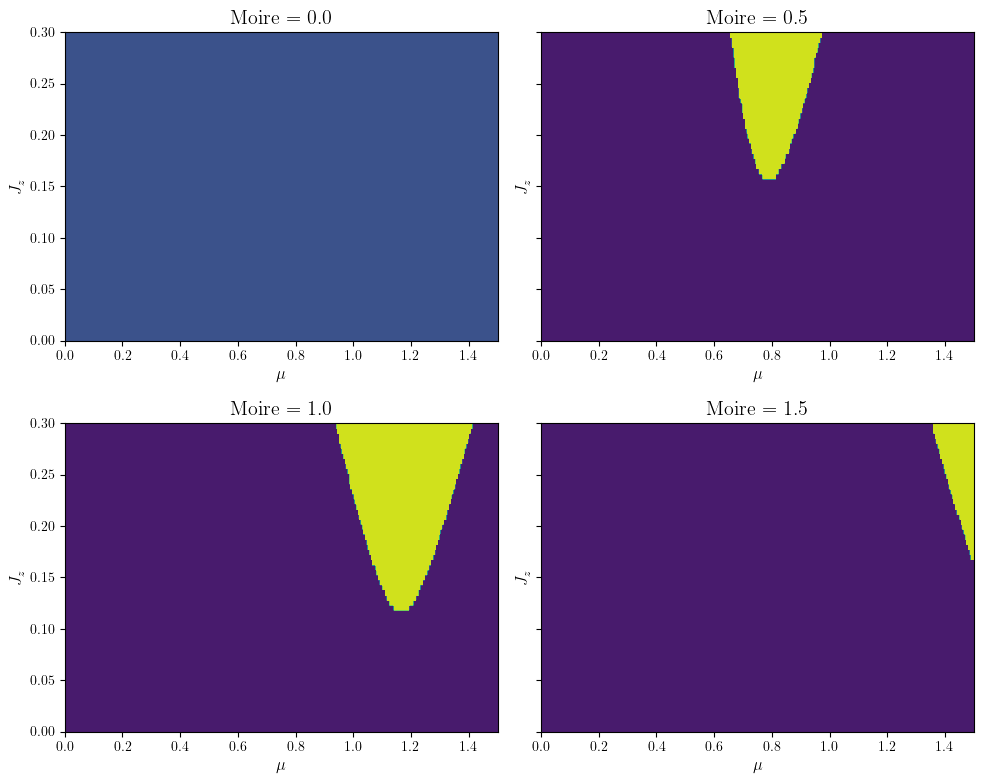

In [72]:
# Moire enabled gap
from utils.conductance_data import ConductanceData
data = ConductanceData()

norm = mpl.colors.Normalize(0, 1)
cmap = mpl.colormaps["viridis"]

num_points = 500
moire_levels = np.linspace(0, 1.5, 4)
fig, axs = plt.subplots(2, 2, sharey="all", figsize=(10, 8))
axs = axs.flatten()
for index, moire in enumerate(moire_levels):
    zeeman = np.linspace(0, 0.3, num_points)
    mu = np.linspace(0, 1.5, num_points)
    mu, zeeman = np.meshgrid(mu, zeeman)
    berry_gap = np.zeros((num_points, num_points, 2))
    for i in range(num_points):
        for j in range(num_points):
            berry, gap = data.get_berry(mu[i, j], zeeman[i, j], moire)
            berry = np.abs(np.round(berry / np.pi))
            berry_gap[i, j, :] = [berry, gap]
            
    color = berry_gap[:, :, 0]
    axs[index].contourf(mu, zeeman, color)
    axs[index].set_xlabel("$\mu$")
    axs[index].set_title(f"Moire = {moire}")
    axs[index].set_ylabel("$J_z$")

plt.savefig("physics/moire_berry.png", dpi=1000)
plt.show()